# Biforcating Tree Dataset

This dataset intends to create a biforcating tree with 8 samples, three runs per sample.


In [1]:
import utils
import gzip
import random
import string
import math

In [2]:
seed = 1003
genome_size = 1 # mbp
num_samples = 8
num_runs = 3

mean_n_reads = 5e5
sd_n_reads = mean_n_reads * 0.1 # Coeff of Var = 0.1
min_n_reads = mean_n_reads / 100.0

countgraph_size = 1e8

### Don't edit below here

Constants are all in the cell above this

In [3]:
! rm -rf data 
! mkdir data
for subdir  in ['genomes', 'fastq', 'countgraphs']:
    ! mkdir data/{subdir}

Set a random seed and seed the RNG

In [4]:
random.seed(seed)
utils.random.seed(seed)

Make a random genome, and samples derived from it. Write it to a fasta file.

In [5]:
genome = utils.make_rand_genome(mbp=genome_size)

In [6]:
levels = int(math.ceil(math.log2(num_samples)))

In [7]:
bifork = utils.biforcating_sequences(genome, levels=levels, av_rate=0.0001, sd_rate=0.00001)
seqlist = list(utils.flatten(bifork))

at level 3 (a rate: 8.999967781387143e-05 b rate: 0.0001263602952565167 )
at level 2 (a rate: 0.00010728051339545256 b rate: 0.00010435283899823592 )
at level 1 (a rate: 7.825364359271761e-05 b rate: 0.00010895982859233916 )
at level 1 (a rate: 9.91161984107852e-05 b rate: 9.891513991261868e-05 )
at level 2 (a rate: 0.00010375680317206128 b rate: 9.06340870557045e-05 )
at level 1 (a rate: 0.00010328984022904547 b rate: 6.486870322429027e-05 )
at level 1 (a rate: 9.586055268263014e-05 b rate: 9.536015252797977e-05 )


In [8]:
with open("data/bifork.fas", 'w') as fh:
    utils.print_multifasta(seqlist, file=fh)

## Make NJ tree


In [9]:
from skbio import Alignment, DNA, DistanceMatrix
from skbio.tree import nj
import numpy as np

In [10]:
aln = Alignment.read('data/bifork.fas')

In [11]:
distmat = aln.distances()

Make a repeated version of this distance matrix, which can be directly (visually) compared with the result of kWIP, which will of course be of the runs, not the genomes themselves.

In [12]:
distmat_reps = DistanceMatrix(
    np.repeat(np.repeat(distmat.data,num_runs, axis=1), num_runs, axis=0))

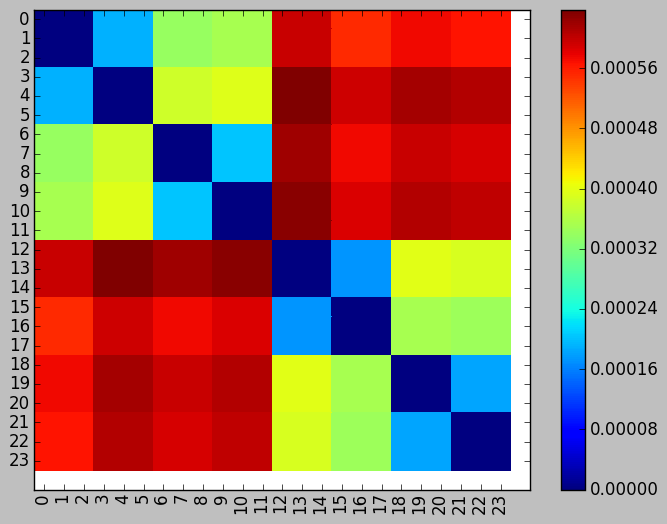

In [13]:
distmat_reps

In [14]:
tree_reps = nj(distmat_reps)
tree_reps.write('data/bifork_runs.nwk')

'data/bifork_runs.nwk'

### Generate reads

In [15]:
genomes = {}
runs = []
r2g = {}
for i, seq in enumerate(seqlist):
    genome = string.ascii_uppercase[i]
    print('Genome', genome, end=', reps: ')
    genomes[genome] = []
    
    # write genome
    fas = 'data/genomes/bifork_{}.fasta'.format(genome)
    with open(fas, 'wb') as fh:
        fh.write(">{}\n{}\n".format(genome, seq).encode('ascii'))
    
    # create each run
    for j in range(num_runs):
        print(j, end=' ')
        fq = "data/fastq/bifork_{}-{}_il.fq".format(genome, j)
        n_reads = max(int(random.gauss(mean_n_reads, sd_n_reads)), min_n_reads)
        utils.wgsim(n_reads, fas, fq)
        genomes[genome].append(fq)
        runs.append(fq)
        r2g[fq] = genome
    print()

Genome A, reps: 0 1 2 
Genome B, reps: 0 1 2 
Genome C, reps: 0 1 2 
Genome D, reps: 0 1 2 
Genome E, reps: 0 1 2 
Genome F, reps: 0 1 2 
Genome G, reps: 0 1 2 
Genome H, reps: 0 1 2 


### Hash samples

In [16]:
def countgraph(fq, cg, x=1e9, k=20, n=1, quiet=True):
    lic = "load-into-countgraph.py -N {N} -k {k} -x {x} -s tsv -b {cg} {fq}".format(
            N=n, k=k, x=x, cg=cg, fq=fq)
    print(lic)
    utils.run_cmd(lic, quiet)

In [17]:
countgraphs = []
for genome in genomes:
    for i, fq in enumerate(genomes[genome]):
        cg = 'data/countgraphs/bifork_{}-{}.cg'.format(genome, i)
        countgraphs.append(cg)
        countgraph(fq, cg, x=countgraph_size, k=20)

load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_A-0.cg data/fastq/bifork_A-0_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_A-1.cg data/fastq/bifork_A-1_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_A-2.cg data/fastq/bifork_A-2_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_G-0.cg data/fastq/bifork_G-0_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_G-1.cg data/fastq/bifork_G-1_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_G-2.cg data/fastq/bifork_G-2_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_D-0.cg data/fastq/bifork_D-0_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.0 -s tsv -b data/countgraphs/bifork_D-1.cg data/fastq/bifork_D-1_il.fq
load-into-countgraph.py -N 1 -k 20 -x 100000000.

## Run `kWIP`

In [18]:
def kwip(countgraphs, dist, kern='', quiet=True):
    if kern:
        kern = '-k {kern}'.format(kern=kern)
    cgs = ' '.join(countgraphs)
    cmd = "kwip {kern} -d {dist} {cgs}".format(kern=kern, dist=dist, cgs=cgs)
    print(cmd)
    utils.run_cmd(cmd, quiet)
   

In [19]:
kwip(sorted(countgraphs), 'data/bifork-kwip.dist', 'data/bifork-kwip.kern')

kwip -k data/bifork-kwip.kern -d data/bifork-kwip.dist data/countgraphs/bifork_A-0.cg data/countgraphs/bifork_A-1.cg data/countgraphs/bifork_A-2.cg data/countgraphs/bifork_B-0.cg data/countgraphs/bifork_B-1.cg data/countgraphs/bifork_B-2.cg data/countgraphs/bifork_C-0.cg data/countgraphs/bifork_C-1.cg data/countgraphs/bifork_C-2.cg data/countgraphs/bifork_D-0.cg data/countgraphs/bifork_D-1.cg data/countgraphs/bifork_D-2.cg data/countgraphs/bifork_E-0.cg data/countgraphs/bifork_E-1.cg data/countgraphs/bifork_E-2.cg data/countgraphs/bifork_F-0.cg data/countgraphs/bifork_F-1.cg data/countgraphs/bifork_F-2.cg data/countgraphs/bifork_G-0.cg data/countgraphs/bifork_G-1.cg data/countgraphs/bifork_G-2.cg data/countgraphs/bifork_H-0.cg data/countgraphs/bifork_H-1.cg data/countgraphs/bifork_H-2.cg


## Analyse the output 


In [20]:
from skbio import DistanceMatrix
from skbio.tree import nj


Make a tree from `kWIP`'s output

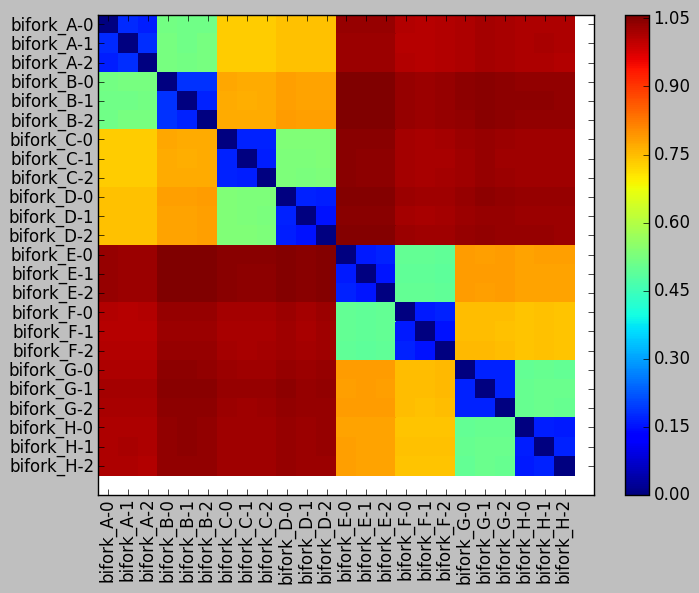

In [21]:
kwip_dist = DistanceMatrix.read("data/bifork-kwip.dist")
kwip_dist

In [22]:
kwip_tree = nj(kwip_dist)
kwip_tree.write('data/bifork_kwip.nwk')

'data/bifork_kwip.nwk'

## Robinson-Foulds distance

A measure of tree concordance. Smaller is better

In [23]:
import ete3
from ete3 import Tree

In [24]:
true_tree = Tree("data/bifork_runs.nwk")
kwip_tree = Tree("data/bifork_kwip.nwk")

And the RF distance is....

In [25]:
kwip_tree.robinson_foulds(true_tree, unrooted_trees=True)[0]

0

## Hierarchical clustering

And ploting by matplotlib

In [26]:
from scipy.cluster import hierarchy as hier
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

In [28]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [29]:
z = hier.linkage(kwip_dist.condensed_form(), method='complete')

In [30]:
names = [x.split('_')[1] for x in kwip_dist.ids]

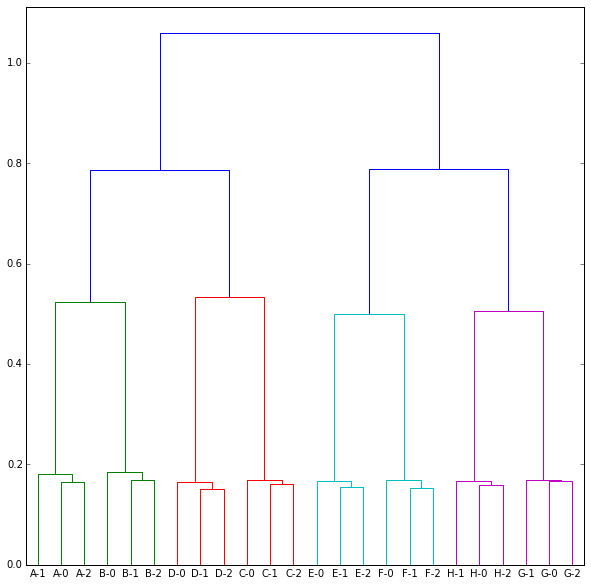

In [31]:
plt.figure()
x = hier.dendrogram(z, labels=names)